In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from mainnet_launch.constants import *
from mainnet_launch.database.schema.ensure_tables_are_current.using_3rd_party.save_local_swap_matrix_all_autopools import (
    get_autopool_possible_assets,
)


# put this as a max date Timestamp('2025-09-29 18:34:41.714165+0000', tz='UTC')


def tidy_up_quotes(df: pd.DataFrame, token_address_to_decimals: dict, token_address_to_symbol: dict) -> pd.DataFrame:

    df = df.dropna(subset=["buyAmount", "minBuyAmount", "sellAmount", "buyToken", "sellToken"]).copy()
    df["datetime_received"] = pd.to_datetime(df["datetime_received"], utc=True)

    df["buy_amount_norm"] = df.apply(
        lambda row: int(row["buyAmount"]) / 10 ** token_address_to_decimals[row["buyToken"]], axis=1
    )
    df["min_buy_amount_norm"] = df.apply(
        lambda row: int(row["minBuyAmount"]) / 10 ** token_address_to_decimals[row["buyToken"]], axis=1
    )
    df["sell_amount_norm"] = df.apply(
        lambda row: int(row["sellAmount"]) / 10 ** token_address_to_decimals[row["sellToken"]], axis=1
    )

    df["buy_amount_price"] = df.apply(lambda row: row["buy_amount_norm"] / row["sell_amount_norm"], axis=1)
    df["min_buy_amount_price"] = df.apply(lambda row: row["min_buy_amount_norm"] / row["sell_amount_norm"], axis=1)
    df["buy_symbol"] = df.apply(lambda row: token_address_to_symbol[row["buyToken"]], axis=1)
    df["sell_symbol"] = df.apply(lambda row: token_address_to_symbol[row["sellToken"]], axis=1)
    df["label"] = df["sell_symbol"] + " -> " + df["buy_symbol"]

    df["safe_value_bought"] = df.apply(lambda row: row["buy_token_price"] * row["buy_amount_norm"], axis=1)
    df["safe_value_min_bought"] = df.apply(lambda row: row["buy_token_price"] * row["min_buy_amount_norm"], axis=1)
    df["safe_value_sold"] = df.apply(lambda row: row["sell_token_price"] * row["sell_amount_norm"], axis=1)
    df["safe_value_slippage_bps"] = df.apply(
        lambda row: 1_000 * (row["safe_value_sold"] - row["safe_value_bought"]) / row["safe_value_sold"], axis=1
    )
    df["long_label"] = df["label"] + " " + df["sell_amount_norm"].astype(int).astype(str)

    df["30_min_chunk"] = pd.to_datetime(df["datetime_received"]).dt.floor("30min")
    return df


bad_autopools = [BASE_EUR, SILO_ETH, SONIC_USD, BAL_ETH, DINERO_ETH, ARB_USD, SILO_USD, AUTO_LRT, ARB_USD]

# 20 worker max date
max_date = pd.to_datetime("2025-09-29 18:34:41.714165+0000", utc=True)

autopool_to_slippage = {}
for autopool in ALL_AUTOPOOLS:
    if autopool not in bad_autopools:
        swap_matrix_data2 = WORKING_DATA_DIR / "swap_matrix_prices2"
        with_spot_prices_save_name = swap_matrix_data2 / f"{autopool.name}_full_swap_matrix_with_prices.csv"
        df = pd.read_csv(with_spot_prices_save_name, low_memory=False)

        assets = get_autopool_possible_assets(autopool)
        token_address_to_symbol = assets.set_index("token_address")["symbol"].to_dict()
        token_address_to_decimals = assets.set_index("token_address")["decimals"].to_dict()
        df = tidy_up_quotes(df, token_address_to_decimals, token_address_to_symbol)
        autopool_to_slippage[autopool.name] = df
        # co
        # unique_slippage_values = (
        #     df.groupby(["30_min_chunk", "long_label"])[["datetime_received", "safe_value_slippage_bps", "buy_symbol"]]
        #     .first()
        #     .reset_index()
        # )

        # slippage_over_time = unique_slippage_values.pivot(
        #     index="30_min_chunk", columns="long_label", values="safe_value_slippage_bps"
        # )
        # autopool_to_slippage[autopool.name] = (df, slippage_over_time)
        # print(f"Read {len(df)} rows for {with_spot_prices_save_name}")

In [55]:
outlier_slippage = 10000  # # autoUSD bad slppage values for lifi, always 2bps higher than the other aggregators
df = autopool_to_slippage["autoDOLA"]
df = df[df["safe_value_slippage_bps"] < outlier_slippage].copy()

px.ecdf(
    df,
    x="safe_value_slippage_bps",
    color="aggregatorName",
    title="Histogram of slippage bps (outliers removed)",
).show()

In [57]:
erc4626_df = df[df["aggregatorName"] == "4626"]
erc4626_df["label"].value_counts()

label
scrvUSD -> sUSDS    8
sUSDe -> alUSD      7
DOLA -> sUSDS       7
sUSDS -> USR        7
scrvUSD -> deUSD    7
sUSDe -> deUSD      7
sUSDe -> sUSDS      7
sUSDe -> sDOLA      6
sUSDS -> sDOLA      6
sUSDS -> deUSD      6
USR -> sDOLA        6
deUSD -> scrvUSD    6
scrvUSD -> alUSD    6
sUSDe -> DOLA       6
sUSDe -> USR        6
sUSDS -> scrvUSD    6
sUSDe -> reUSD      6
sDOLA -> USR        6
reUSD -> scrvUSD    5
deUSD -> sUSDS      5
sDOLA -> scrvUSD    5
sDOLA -> DOLA       5
sUSDe -> scrvUSD    5
scrvUSD -> USR      5
sUSDS -> DOLA       5
reUSD -> sDOLA      5
DOLA -> scrvUSD     5
alUSD -> sUSDe      5
deUSD -> sDOLA      5
sDOLA -> sUSDS      5
alUSD -> sUSDS      4
sDOLA -> deUSD      4
scrvUSD -> sDOLA    4
sUSDS -> reUSD      4
sUSDS -> sUSDe      4
sUSDS -> alUSD      4
USR -> sUSDS        4
alUSD -> scrvUSD    4
deUSD -> sUSDe      4
reUSD -> sUSDS      4
USR -> scrvUSD      3
sDOLA -> alUSD      3
scrvUSD -> reUSD    3
scrvUSD -> sUSDe    3
scrvUSD -> DOLA     3
DOLA

In [43]:
sorted_labels = df.groupby("label")["safe_value_slippage_bps"].median().sort_values().index
px.box(df, x="label", y="safe_value_slippage_bps", category_orders={"label": sorted_labels}).show()

In [44]:
px.histogram(
    df,
    x="safe_value_slippage_bps",
    color="aggregatorName",
    nbins=100,
    title="Histogram of slippage bps (outliers removed)",
).show()

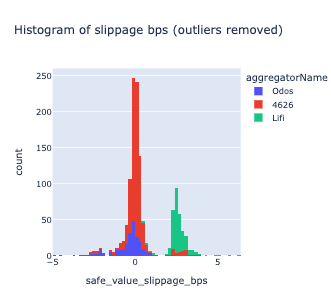

lifi is giving worse quotes, by and large, 

might be because 

In [33]:
df.groupby("aggregatorName")["safe_value_slippage_bps"].mean()

aggregatorName
4626    0.138492
Lifi    2.646709
Odos   -0.492837
Name: safe_value_slippage_bps, dtype: float64

In [16]:
px.scatter(df, x="datetime_received", y="safe_value_slippage_bps", color="long_label").show()

In [ ]:
# not sure why this has 2 cneters

NameError: name 'outlier_slippage' is not defined

In [9]:
autopool = AUTO_USD
df, _ = autopool_to_slippage[autopool.name]

all_slippage_values = (
    df.groupby(["30_min_chunk", "long_label"])[["datetime_received", "safe_value_slippage_bps", "buy_symbol"]]
    .first()
    .reset_index()
)
px.scatter(
    all_slippage_values,
    x="datetime_received",
    y="safe_value_slippage_bps",
    color="buy_symbol",
    hover_name="long_label",
    title=f"All tokens {autopool.name} slippage over time",
).show()

In [5]:
def plot_by_bought_token_histograms(autopool: AutopoolConstants) -> None:
    df, _ = autopool_to_slippage[autopool.name]

    all_slippage_values = (
        df.groupby(["30_min_chunk", "long_label"])[["datetime_received", "safe_value_slippage_bps", "buy_symbol"]]
        .first()
        .reset_index()
    )

    slippage_over_time = all_slippage_values.pivot(
        index="30_min_chunk", columns="long_label", values="safe_value_slippage_bps"
    )
    time_ago = slippage_over_time.shift(1)  # 30 - 60 min ago

    absolute_diff = slippage_over_time - time_ago

    low, high = np.percentile(absolute_diff.dropna().values, [5, 95])

    fig = px.histogram(
        absolute_diff,
        title=f"All tokens {autopool.name}, 30-60 minutes ago",
    )

    fig.add_vline(
        x=low,
        line_dash="dash",
        line_color="red",
        annotation_text=f"Bottom 5th% {low:.1f}",
        annotation_position="top left",
    )
    fig.add_vline(
        x=high,
        line_dash="dash",
        line_color="red",
        annotation_text=f"Top 95th% {high:.1f}",
        annotation_position="top right",
    )
    fig.show()

    for token in df["buy_symbol"].unique():
        sub_df = df[df["buy_symbol"] == token]

        unique_slippage_values = (
            sub_df.groupby(["30_min_chunk", "long_label"])[
                ["datetime_received", "safe_value_slippage_bps", "buy_symbol"]
            ]
            .first()
            .reset_index()
        )

        slippage_over_time = unique_slippage_values.pivot(
            index="30_min_chunk", columns="long_label", values="safe_value_slippage_bps"
        )
        time_ago = slippage_over_time.shift(1)  # 30 - 60 min ago

        absolute_diff = slippage_over_time - time_ago

        low, high = np.percentile(absolute_diff.dropna(), [5, 95])
        not_na_count = absolute_diff.notna().sum().sum()
        total_count = absolute_diff.size
        percent_not_na = (not_na_count / total_count) * 100
        print(f"{autopool.name} {token}")
        print(f"Not NA values: {not_na_count}")
        print(f"Total values: {total_count}")
        print(f"Percent not NA: {percent_not_na:.2f}%")

        fig = px.ecdf(
            absolute_diff,
            title=f"Buying {token} {autopool.name}, 30-60 minutes ago",
        )

        fig.add_vline(
            x=low,
            line_dash="dash",
            line_color="red",
            annotation_text=f"Bottom 5th% {low:.1f}",
            annotation_position="top left",
        )
        fig.add_vline(
            x=high,
            line_dash="dash",
            line_color="red",
            annotation_text=f"Top 95th% {high:.1f}",
            annotation_position="top right",
        )
        fig.show()


# each of these samples only has ~11ish instances, (not enough) need ot run it for a couple of days and then come back
plot_by_bought_token_histograms(AUTO_USD)

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
# silently missing values
px.box(
    slippage_over_time[sorted_slippage.index],
    title=f"Swap cost bps over time {autopool.name} (sorted by median)",
    orientation="h",
    height=900,
    width=900,
).show()

In [ ]:
df.pivot(index="datetime_received", columns="long_label", values="safe_value_slippage_bps")

In [ ]:
px.scatter(df, title="Swap cost bps over time autoETH").show()

In [ ]:
100 * (slippage_over_time.isna().sum() / len(slippage_over_time)).describe()

In [ ]:
pass

In [ ]:
columns_without_frx_ETH = [col for col in slippage_over_time.columns if "rETH" not in col]
non_frx_slippage = slippage_over_time[columns_without_frx_ETH]
sorted_slippage = non_frx_slippage.median().sort_values()

px.box(
    non_frx_slippage[sorted_slippage.index],
    title="Swap cost bps over time autoETH (sorted by median)",
    orientation="h",
    height=1000,
).show()

In [ ]:
columns_with_frx_ETH = [col for col in slippage_over_time.columns if "rETH" in col]
frx_slippage = slippage_over_time[columns_with_frx_ETH]

px.box(
    frx_slippage[frx_slippage.median().sort_values().index],
    title="Swap cost bps over time autoETH (sorted by median)",
    orientation="h",
    height=1000,
).show()

In [ ]:
# on base eth  -> swapping to rETH is lower slippage and swapping from rETH is higher slippage

In [ ]:
# at least in this sample

In [ ]:
percent_na = non_frx_slippage.isna().mean() * 100
percent_na

In [ ]:
slippage_over_time

In [ ]:
for i, label in enumerate(["30_min_ago", "60_min_ago", "90_min_ago", "120_min_ago"]):
    time_ago = slippage_over_time.shift(i + 1)

    absolute_diff = (slippage_over_time - time_ago).abs()

    px.histogram(absolute_diff, title=f"Absolute difference in swap cost bps from 30 min ago autoETH, {label}").show()

In [ ]:
hour_ago = slippage_over_time.shift(3)
absolute_diff = (slippage_over_time - hour_ago).abs()

px.histogram(absolute_diff, title="Absolute difference in swap cost bps from 45 min ago").show()

In [ ]:
hour_ago = slippage_over_time.shift(4)
absolute_diff = (slippage_over_time - hour_ago).abs()

px.histogram(absolute_diff, title="Absolute difference in swap cost bps from 1 hour ago").show()

In [ ]:
px.box(slippage_over_time)
# slippage values are veyr tight, typically 2-3 bps, a few higher and a few lower

In [ ]:
def compute_bps_diff_thresholds(slippage_over_time, column: str, percentile) -> pd.DataFrame:
    one_token_prices = slippage_over_time[[column]].copy()
    one_token_prices["t-15"] = one_token_prices[column].shift(1)
    one_token_prices["t-30"] = one_token_prices[column].shift(2)
    one_token_prices["t-45"] = one_token_prices[column].shift(3)
    one_token_prices["t-60"] = one_token_prices[column].shift(4)
    one_token_prices["t-120"] = one_token_prices[column].shift(8)
    one_token_prices["t-180"] = one_token_prices[column].shift(12)
    one_token_prices["bps_diff_15_min"] = one_token_prices[column] - one_token_prices["t-15"]
    one_token_prices["bps_diff_30_min"] = one_token_prices[column] - one_token_prices["t-30"]
    one_token_prices["bps_diff_45_min"] = one_token_prices[column] - one_token_prices["t-45"]
    one_token_prices["bps_diff_60_min"] = one_token_prices[column] - one_token_prices["t-60"]
    one_token_prices["bps_diff_120_min"] = one_token_prices[column] - one_token_prices["t-120"]
    one_token_prices["bps_diff_180_min"] = one_token_prices[column] - one_token_prices["t-180"]
    thresholds = one_token_prices.filter(like="bps_diff_").abs().quantile(percentile).rename(column)
    return thresholds


percentile = 0.95


def plot_bps_thresholds_by_size():
    for size in df["sell_amount_norm"].unique().astype(int).astype(str):
        all_thresholds = []
        for i, col in enumerate(slippage_over_time.columns):
            if " " + size not in col:
                continue
            thresholds = compute_bps_diff_thresholds(slippage_over_time, col, percentile)
            all_thresholds.append(thresholds)
        threshold_df = pd.concat(all_thresholds, axis=1).T
        px.box(threshold_df, title=f"{percentile}th percentile of bps diff for size " + size).show()


def plot_bps_diffs_by_label():
    for label in df["buy_symbol"].unique():
        all_thresholds = []

        for i, col in enumerate(slippage_over_time.columns):
            if str(label) in col:
                thresholds = compute_bps_diff_thresholds(slippage_over_time, col, percentile)
                all_thresholds.append(thresholds)

        if len(all_thresholds) == 0:
            print("No data for label", label)
            continue

        threshold_df = pd.concat(all_thresholds, axis=1).T
        px.box(
            threshold_df,
            title=f"{percentile}th percentile of bps diff for label " + label,
        ).show()


def plot_all_bps_diffs():
    all_thresholds = []
    for i, col in enumerate(slippage_over_time.columns):
        thresholds = compute_bps_diff_thresholds(slippage_over_time, col, percentile)
        all_thresholds.append(thresholds)
    threshold_df = pd.concat(all_thresholds, axis=1).T
    px.box(threshold_df, title=f"{percentile}th percentile of bps diff for all").show()


plot_all_bps_diffs()
plot_bps_diffs_by_label()

In [ ]:
plot_bps_thresholds_by_size()